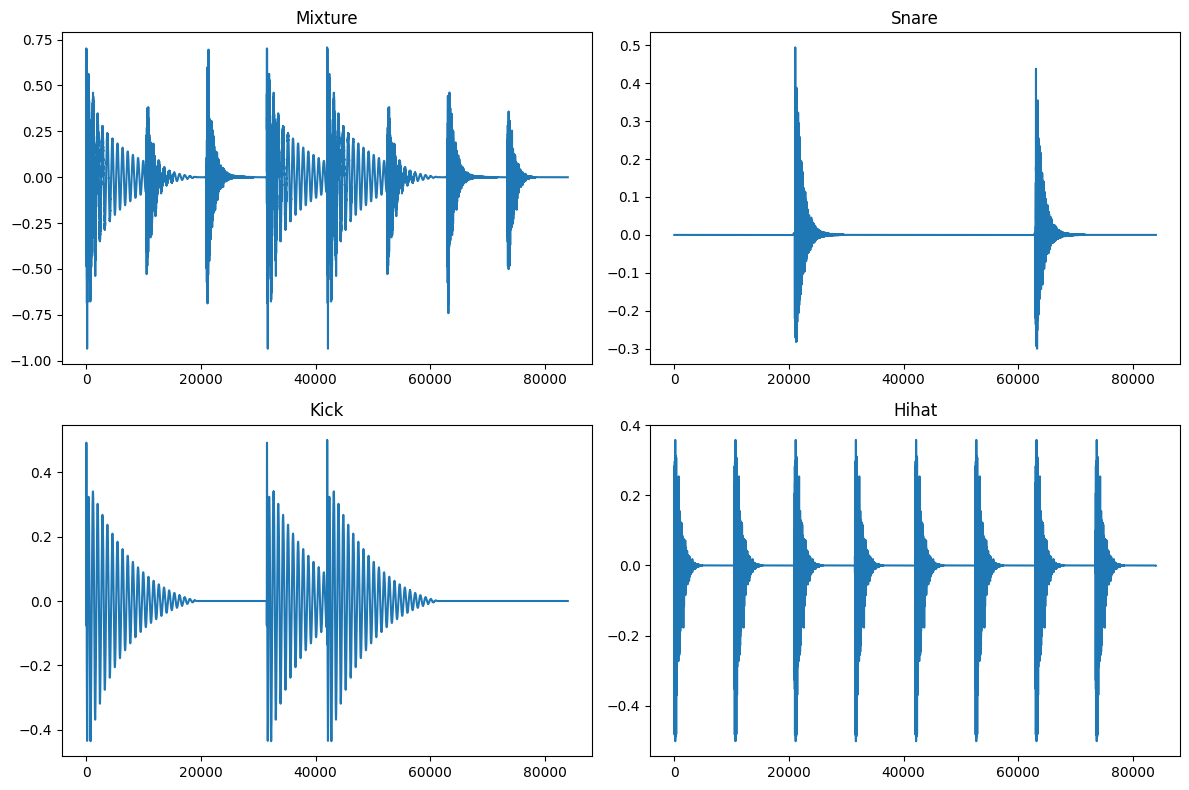

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.decomposition import NMF

# Load audio files
inpPath = '/content/drive/MyDrive/data'
filename = '/runningExample_808Mixture.wav'
x, fs = librosa.load(inpPath + filename, sr=None)

filename2 = '/runningExample_808Snare.wav'
x2, fs2 = librosa.load(inpPath + filename2, sr=None)

filename3 = '/runningExample_808Kick.wav'
x3, fs3 = librosa.load(inpPath + filename3, sr=None)

filename4 = '/runningExample_808Hihat.wav'
x4, fs4 = librosa.load(inpPath + filename4, sr=None)

# Plot the audio signals
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(x[:83990])
plt.title('Mixture')

plt.subplot(2, 2, 2)
plt.plot(x2[:83990])
plt.title('Snare')

plt.subplot(2, 2, 3)
plt.plot(x3[:83990])
plt.title('Kick')

plt.subplot(2, 2, 4)
plt.plot(x4[:83990])
plt.title('Hihat')

plt.tight_layout()
plt.show()

# STFT

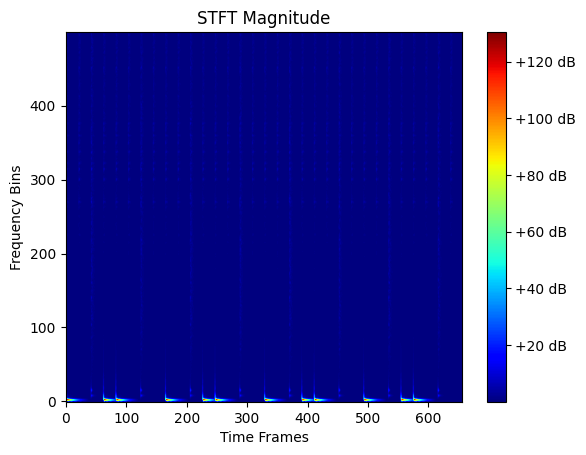

Number of Bins: 1025
Number of Frames: 657
Time Resolution: 0.0116 s
Frequency Resolution: 21.5332 Hz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def forwardSTFT(x, param):
    blockSize = param.get('blockSize', 2048)
    hopSize = param.get('hopSize', 512)
    winFunc = param.get('winFunc', np.hanning(blockSize))
    reconstMirror = param.get('reconstMirror', True)
    appendFrame = param.get('appendFrame', True)

    halfBlockSize = blockSize // 2
    numBins = blockSize // 2 + 1 if reconstMirror else blockSize

    if appendFrame:
        x = np.concatenate((np.zeros(halfBlockSize), x, np.zeros(halfBlockSize)))

    numFrames = (len(x) - blockSize) // hopSize + 1
    X = np.zeros((numBins, numFrames), dtype=complex)

    for k in range(0, len(x) - blockSize, hopSize):
        ind = np.arange(k, k + blockSize)
        snip = x[ind] * winFunc
        f = np.fft.fft(snip, blockSize)
        if reconstMirror:
            f = f[:numBins]
        X[:, k // hopSize] = f

    A = np.abs(X)
    P = np.angle(X)
    return X, A, P

# Load audio file
inpPath = '/content/drive/MyDrive/data'
filename = '/runningExample_808Mixture.wav'
x, fs = librosa.load(inpPath + filename, sr=None)

# Spectral parameters
tw = np.concatenate((np.linspace(-0.5, -1/2048, 1024), np.linspace(0, 0.5-1/2048, 1024)))
sigma = 0.35
g = np.exp(-np.pi / sigma**2 * tw**2)

paramSTFT = {
    'blockSize': 2048,
    'hopSize': 512,
    'winFunc': g,
    'reconstMirror': True,
    'appendFrame': True,
    'numSamples': len(x)
}

# Compute STFT
X, A, P = forwardSTFT(x, paramSTFT)

# Display STFT magnitude
plt.figure()
plt.imshow(np.abs(X[:500, :]), aspect='auto', origin='lower', cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Magnitude')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.show()

# Get dimensions and time and freq resolutions
numBins, numFrames = X.shape
deltaT = paramSTFT['hopSize'] / fs
deltaF = fs / paramSTFT['blockSize']

print(f"Number of Bins: {numBins}")
print(f"Number of Frames: {numFrames}")
print(f"Time Resolution: {deltaT:.4f} s")
print(f"Frequency Resolution: {deltaF:.4f} Hz")


In [ ]:
import numpy as np

def NMF(V, parameter):
    if 'costFunc' not in parameter:
        parameter['costFunc'] = 'KLDiv'
    if 'numIter' not in parameter:
        parameter['numIter'] = 30
    if 'fixW' not in parameter:
        parameter['fixW'] = 0

    # Get important parameters
    K, M = V.shape
    R = parameter['numComp']
    L = parameter['numIter']
    onesMatrix = np.ones((K, M))

    # Initialization of W and H
    if isinstance(parameter['initW'], list):
        W = np.array(parameter['initW'])
    else:
        W = parameter['initW']
    H = parameter['initH']

    # Normalize V
    V = V / (np.finfo(float).eps + np.sum(V))

    # Main iterations
    for iter in range(1, L+1):
        # Compute approximation
        Lambda = np.finfo(float).eps + (W @ H)

        # Switch between pre-defined update rules
        if parameter['costFunc'] == 'KLDiv':
            if not parameter['fixW']:
                W = W * ((V / Lambda) @ H.T) / (onesMatrix @ H.T + np.finfo(float).eps)
            H = H * (W.T @ (V / Lambda)) / (W.T @ onesMatrix + np.finfo(float).eps)
        else:
            raise ValueError('Unknown cost function')

        # Normalize templates to unit sum
        if not parameter['fixW']:
            normVec = np.sum(W, axis=0)
            W = W / (np.finfo(float).eps + normVec)

    # Compute final output approximation
    nmfV = [W[:, r][:, np.newaxis] @ H[r][np.newaxis, :] for r in range(R)]

    return W, H, nmfV

# Assuming 'A' is your magnitude spectrogram matrix
# Set common parameters
numComp = 3
numIter = 30

# Generate initial guess for templates
initW = np.random.rand(A.shape[0], numComp)

# Generate initial activations
initH = np.random.rand(numComp, A.shape[1])

# NMF parameters
paramNMF = {
    'numComp': numComp,
    'numFrames': A.shape[1],
    'numIter': numIter,
    'initW': initW,
    'initH': initH,
    'costFunc': 'KLDiv',  # Assuming Kullback-Leibler divergence
}

# NMFD core method
nmfdW, nmfdH, nmfdV = NMF(A, paramNMF)

In [ ]:
def alphaWienerFilter(mixtureX, sourceA, alpha=1, binarize=False):
    numBins, numFrames = mixtureX.shape
    numComp = len(sourceA)
    mixtureA = np.zeros((numBins, numFrames)) + np.finfo(float).eps

    # Make superposition
    for k in range(numComp):
        mixtureA += sourceA[k]**alpha

    sourceX = []
    softMasks = []

    # Compute soft masks and spectrogram estimates
    for k in range(numComp):
        currSoftMask = sourceA[k]**alpha / mixtureA
        softMasks.append(currSoftMask)

        # Binarize the mask if desired
        if binarize:
            softMasks[k] = softMasks[k] > (1 / numComp)

        # Apply the mask to the mixture
        sourceX.append(mixtureX * currSoftMask)

    return sourceX, softMasks

# Alpha-Wiener filtering (assuming k iterates through the source components)
nmfdA, _ = alphaWienerFilter(A, nmfdV, 1)


In [ ]:
def inverseSTFT(X, parameter):
    if 'blockSize' not in parameter:
        parameter['blockSize'] = 2048
    if 'hopSize' not in parameter:
        parameter['hopSize'] = 512
    if 'winFunc' not in parameter:
        parameter['winFunc'] = np.hanning(parameter['blockSize'])

    reconstMirror = parameter.get('reconstMirror', numBins < parameter['blockSize'])
    appendFrame = parameter.get('appendFrame', True)
    analyticSig = parameter.get('analyticSig', False)
    blockSize = parameter['blockSize']
    halfBlockSize = round(blockSize / 2)
    hopSize = parameter['hopSize']

    anaWinFunc = parameter['winFunc']
    synWinFunc = parameter['winFunc']

    if analyticSig:
        reconstMirror = False
        scale = 2
    else:
        scale = 1

    numBins, numFrames = X.shape

    sigLen = (numFrames) * hopSize + blockSize
    y = np.zeros(sigLen)
    win_norm = np.zeros(sigLen)

    env = np.zeros(blockSize)
    winFuncProd = anaWinFunc * synWinFunc
    redundancy = round(blockSize / hopSize)

    for k in range(-(redundancy - 1), redundancy):
        envInd = (hopSize * (k))
        envInd = envInd + np.arange(1, blockSize + 1)

        valid = np.where((envInd > 0) & (envInd <= blockSize))
        envInd = envInd[valid]
        winInd = np.arange(1, blockSize + 1)[valid]

        env[envInd - 1] = env[envInd - 1] + winFuncProd[winInd - 1]

    synWinFunc = synWinFunc / env

    winInd = np.arange(1, blockSize + 1)

    for k in range(numFrames):
        currSpec = X[:, k]

        if reconstMirror:
            if not analyticSig:
                currSpec = np.concatenate((currSpec, np.flipud(np.conj(currSpec[1:-1]))))
            else:
                currSpec = np.concatenate((currSpec, np.zeros((blockSize // 2 - 1,))))

        snip = np.fft.ifft(currSpec, blockSize)
        if not analyticSig:
            snip = np.real(snip)

        snip = scale * snip * synWinFunc

        envInd = (hopSize * (k))
        envInd = envInd + winInd

        y[envInd - 1] = y[envInd - 1] + snip
        win_norm[envInd - 1] = win_norm[envInd - 1] + anaWinFunc * synWinFunc

    y = y / win_norm

    if appendFrame:
        y = y[halfBlockSize:-halfBlockSize]

    if 'numSamples' in parameter:
        y = y[:parameter['numSamples']]

    return y

In [ ]:

def inverseSTFT(X, parameter):
    if 'blockSize' not in parameter:
        parameter['blockSize'] = 2048
    if 'hopSize' not in parameter:
        parameter['hopSize'] = 512
    if 'winFunc' not in parameter:
        parameter['winFunc'] = np.hanning(parameter['blockSize'])

    reconstMirror = parameter.get('reconstMirror', numBins < parameter['blockSize'])
    appendFrame = parameter.get('appendFrame', True)
    analyticSig = parameter.get('analyticSig', False)
    blockSize = parameter['blockSize']
    halfBlockSize = round(blockSize / 2)
    hopSize = parameter['hopSize']

    anaWinFunc = parameter['winFunc']
    synWinFunc = parameter['winFunc']

    if analyticSig:
        reconstMirror = False
        scale = 2
    else:
        scale = 1

    numBins, numFrames = X.shape

    sigLen = (numFrames) * hopSize + blockSize
    y = np.zeros(sigLen)
    win_norm = np.zeros(sigLen)

    env = np.zeros(blockSize)
    winFuncProd = anaWinFunc * synWinFunc
    redundancy = round(blockSize / hopSize)

    for k in range(-(redundancy - 1), redundancy):
        envInd = (hopSize * (k))
        envInd = envInd + np.arange(1, blockSize + 1)

        valid = np.where((envInd > 0) & (envInd <= blockSize))
        envInd = envInd[valid]
        winInd = np.arange(1, blockSize + 1)[valid]

        env[envInd - 1] = env[envInd - 1] + winFuncProd[winInd - 1]

    synWinFunc = synWinFunc / env

    winInd = np.arange(1, blockSize + 1)

    for k in range(numFrames):
        currSpec = X[:, k]

        if reconstMirror:
            if not analyticSig:
                currSpec = np.concatenate((currSpec, np.flipud(np.conj(currSpec[1:-1]))))
            else:
                currSpec = np.concatenate((currSpec, np.zeros((blockSize // 2 - 1,))))

        snip = np.fft.ifft(currSpec, blockSize)
        if not analyticSig:
            snip = np.real(snip)

        snip = scale * snip * synWinFunc

        envInd = (hopSize * (k))
        envInd = envInd + winInd

        y[envInd - 1] = y[envInd - 1] + snip
        win_norm[envInd - 1] = win_norm[envInd - 1] + anaWinFunc * synWinFunc

    y = y / win_norm

    if appendFrame:
        y = y[halfBlockSize:-halfBlockSize]

    if 'numSamples' in parameter:
        y = y[:parameter['numSamples']]

    return y

<ipython-input-11-8b4d05add79c>:64: RuntimeWarning: invalid value encountered in divide
  y /= win_norm


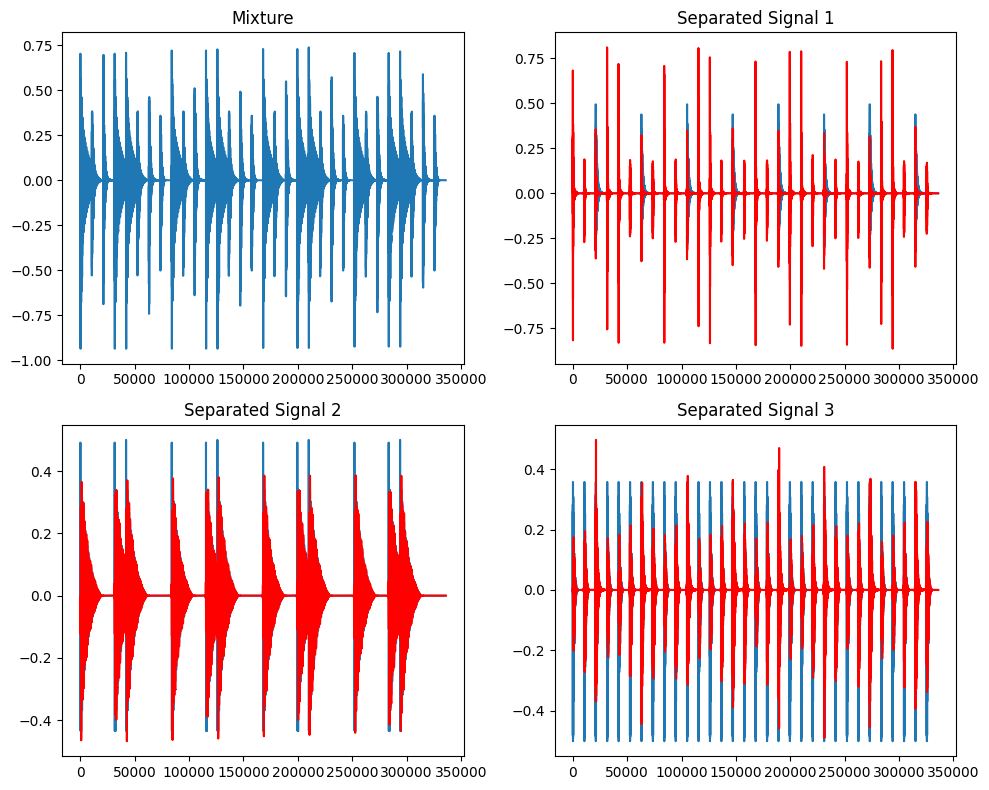

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function for inverse STFT
def inverseSTFT(X, parameter=None):
    if parameter is None:
        parameter = {}

    numBins, numFrames = X.shape
    blockSize = parameter.get('blockSize', 2048)
    hopSize = parameter.get('hopSize', 512)
    winFunc = parameter.get('winFunc', np.hanning(blockSize))

    # Determine if the upper part of the spectrum should be reconstructed
    if 'reconstMirror' not in parameter:
        reconstMirror = numBins < blockSize
    else:
        reconstMirror = parameter['reconstMirror']

    appendFrame = parameter.get('appendFrame', True)
    analyticSig = parameter.get('analyticSig', False)

    if analyticSig:
        reconstMirror = False
        scale = 2
    else:
        scale = 1

    # Initialization
    sigLen = numFrames * hopSize + blockSize
    y = np.zeros(sigLen)
    win_norm = np.zeros(sigLen)
    winFuncProd = winFunc * winFunc
    redundancy = round(blockSize / hopSize)

    env = np.zeros(blockSize)
    for k in range(-redundancy + 1, redundancy):
        envInd = hopSize * k + np.arange(blockSize)
        valid = (envInd >= 0) & (envInd < blockSize)
        envInd = envInd[valid]
        env[envInd] += winFuncProd[valid]

    synWinFunc = winFunc / env
    winInd = np.arange(blockSize)

    for k in range(numFrames):
        currSpec = X[:, k]

        if reconstMirror:
            if not analyticSig:
                currSpec = np.concatenate((currSpec, np.conj(np.flipud(currSpec[1:-1]))))
            else:
                currSpec = np.concatenate((currSpec, np.zeros(blockSize // 2 - 1)))

        snip = np.fft.ifft(currSpec, blockSize)
        if not analyticSig:
            snip = np.real(snip)

        snip = scale * snip * synWinFunc
        envInd = hopSize * k + winInd
        y[envInd] += snip
        win_norm[envInd] += winFuncProd

    y /= win_norm
    if appendFrame:
        y = y[blockSize // 2: -blockSize // 2]

    if 'numSamples' in parameter:
        y = y[:parameter['numSamples']]

    return y

# Assuming nmfdA, P, paramSTFT, x, x2, x3, x4 are already defined



numComp = len(nmfdA)
y = []

for k in range(numComp):
    Y = nmfdA[k] * np.exp(1j * P)
    y.append(inverseSTFT(Y, paramSTFT))

yy = sum(y)

# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot original mixture signal
axs[0, 0].plot(x)
axs[0, 0].set_title('Mixture')

# Plot original and separated sources
axs[0, 1].plot(x2)
axs[0, 1].plot(y[1], 'r')
axs[0, 1].set_title('Separated Signal 1')

axs[1, 0].plot(x3)
axs[1, 0].plot(y[0], 'r')
axs[1, 0].set_title('Separated Signal 2')

axs[1, 1].plot(x4)
axs[1, 1].plot(y[2], 'r')
axs[1, 1].set_title('Separated Signal 3')

plt.tight_layout()
plt.show()